In [11]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd 
import rasterio 
from rasterio.plot import  show, adjust_band
from rasterio.mask import mask
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings 

import geemap, ee 

warnings = False

ee.Initialize()

# исходники 

<AxesSubplot:>

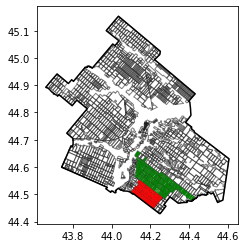

In [12]:
region = gpd.read_file('vector_data/dictrict_bound.geojson')
agriculture = gpd.read_file('vector_data/agriculture.geojson')
archangelskoe = gpd.read_file('vector_data/archangelskoe.geojson')
dobrovolnoe = gpd.read_file('vector_data/dobrovolnoe.geojson')



base = region.boundary.plot(color = 'Black')

agriculture.plot(ax = base , color='white', edgecolor='black', alpha = 0.5)
archangelskoe.plot(ax = base , color = "Green")
dobrovolnoe.plot(ax = base, color = 'Red')


# получение данных 

In [13]:
ndvi_bands = ['B8', 'B4']
ndti_bands = ['B11', 'B12']

agriculture_gee = geemap.geopandas_to_ee(agriculture)


def calulate_NDVI(image):
    NDVI = image.normalizedDifference(ndvi_bands).rename('NDVI').select('NDVI')
    image = image.addBands(NDVI)
    return image
def calulate_NDTI(image):
    NDTI = image.normalizedDifference(ndti_bands).rename('NDTI').select('NDTI')
    image = image.addBands(NDTI)
    return image

def S2masking(image): 
    cloudProb = image.select('MSK_CLDPRB')  # покрытие облаками
    snowProb = image.select('MSK_SNWPRB') # покрытие снегом
    cloud = cloudProb.lt(1) # создали бинарную маску иными словами просто все что имеет значение меньше 5 одна группа выше другая
                        # а мы помним что пиксели принимают значения от 0 до 255
    snow = snowProb.lt(1) # тоже самое что с облаками
    scl = image.select('SCL') # слой с классификатором(есть в sentinel 2 уровня обработки 2А)
    shadow = scl.neq(3);# 3 в классификации это тени от облаков
    cirrus_medium = scl.neq(8) # тоже по классификации облака 
    cirrus_high = scl.neq(9) # аналогично облака
    cirrus = scl.neq(10); # 10 это перистые облака или цирусы
    veg = image.select('NDVI')
    veg_mask = veg.lt(0.25)# маска по NDVI

    return  image.updateMask(cirrus).updateMask(cirrus_medium).updateMask(cirrus_high).updateMask(veg_mask)
def raster_preparing(image):
    image =  calulate_NDVI(image)
    image = S2masking(image)
    image = calulate_NDTI(image)

    return image 
def get_image(date):
    row_image = ee.ImageCollection('COPERNICUS/S2_SR') \
        .filterDate(f"{date}-04-15", f"{date}-11-15") \
        .filterBounds(agriculture_gee) \
        .filterMetadata("CLOUD_COVERAGE_ASSESSMENT", 'less_than', 10.0) \
        .map(raster_preparing)
    print("коллекция получена ")
    minNDTI = row_image.select('NDTI').min()
    minNDTI = minNDTI.clip(agriculture_gee)
    print("minNDTI построен ")

    geemap.ee_export_image_to_drive(minNDTI, description=f'minNDTI{date}', folder='NDTI', region=agriculture_gee.geometry(), scale=20)
    print("minNDTI выгружен в хранилище")

In [14]:
for i in [2019,2020,2021]:
    get_image(i)


коллекция получена 
minNDTI построен 
Exporting minNDTI2019 ...
minNDTI выгружен в хранилище
коллекция получена 
minNDTI построен 
Exporting minNDTI2020 ...
minNDTI выгружен в хранилище
коллекция получена 
minNDTI построен 
Exporting minNDTI2021 ...
minNDTI выгружен в хранилище


In [15]:
with rasterio.open("raster_data/minNDTI_3_years.tif", 'r') as src:
    archan, out_transform = mask(src, archangelskoe.geometry, crop=True, nodata= np.nan)
    dobrovol, out_transform = mask(src, dobrovolnoe.geometry, crop=True, nodata= np.nan)
    out_meta = src.meta